# Prepare synthetic data

- Steve Harris
- 2022-09-11

We need synthetic data.  
We will inspect live data in this notebook, and then derive a short script that will generate suitable dummy data.

**NOTE**

This notebook will be be run manually.  
That should happen from the _project root directory_ where the `readme.md` and the `.env` file are stored.

The following changes to the project root assuming that the notebook kernel is normally starting from the same directory as the notebook itself.

In [1]:
%cd ../..

/data/hymind/home/steve/HyStakes


In [2]:
import os
from dotenv import load_dotenv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson, lognorm
import sqlalchemy as sa

In [3]:
%matplotlib inline

## Load environment variables

Load environment variables and set-up SQLAlchemy connection engine for the EMAP Star

In [4]:
load_dotenv(dotenv_path=".env")
try:
    assert os.getenv("DOTENV_FILE_EXISTS") == 'TRUE'
except AssertionError:
    print("!!! ERROR: check that the .env file exists at the top level of the project")
    print("!!! ERROR: check that the relative path is correct")

In [5]:
# Construct the PostgreSQL connection
uds_host = os.getenv('EMAP_DB_HOST')
uds_name = os.getenv('EMAP_DB_NAME')
uds_port = os.getenv('EMAP_DB_PORT')
uds_user = os.getenv('EMAP_DB_USER')
uds_passwd = os.getenv('EMAP_DB_PASSWORD')

emapdb_engine = sa.create_engine(f'postgresql://{uds_user}:{uds_passwd}@{uds_host}:{uds_port}/{uds_name}')

## Prepare the 'live' query

Here's the _very_ long query that I built.  
It selects all patients on tower wards 2 weeks ago (336 hours), and then finds the age (rounded) and the last heart rate. The remaining data has _no_ identifiers.

```sql

SELECT
 left(md5(lv.hospital_visit_id::TEXT), 6) id
--,lv.location_visit_id
--,lv.admission_datetime admit_dt_bed
--,lv.discharge_datetime disch_dt_bed
--,hv.admission_datetime admit_dt_hosp
--,hv.discharge_datetime disch_dt_hosp
,ROUND(EXTRACT(epoch FROM 
    (hv.discharge_datetime - (NOW() - '336 HOURS'::INTERVAL)
    ))/3600) hours_to_discharge
--,hv.discharge_destination
--,hv.patient_class
--,lo.location_string
,dept.name department

-- include age rounded to 5
, ROUND(DATE_PART('year',AGE(cd.date_of_birth ))/5) * 5 AGE

-- add last heart rate
,hr.value_as_real pulse
--,hr.observation_datetime


FROM star.location_visit lv
LEFT JOIN star.location lo ON lv.location_id = lo.location_id
LEFT JOIN star.department dept ON lo.department_id = dept.department_id 
LEFT JOIN star.hospital_visit hv ON lv.hospital_visit_id = hv.hospital_visit_id
LEFT JOIN star.core_demographic cd ON hv.mrn_id = cd.mrn_id
LEFT JOIN (
    WITH obs AS (
        SELECT

         vo.visit_observation_id
        ,vo.hospital_visit_id
        ,vo.observation_datetime
        ,vo.value_as_real
        ,ot.name

        FROM star.visit_observation vo
        LEFT JOIN star.visit_observation_type ot ON vo.visit_observation_type_id = ot.visit_observation_type_id
        WHERE 
        ot.id_in_application = '8' -- heart rate
        AND
        vo.observation_datetime < NOW() - '336 HOURS'::INTERVAL 
        AND
        vo.observation_datetime > NOW() - '360 HOURS'::INTERVAL 
    ),
    obs_tail AS (
        SELECT 
         obs.*
        ,row_number() over (partition BY obs.hospital_visit_id ORDER BY obs.observation_datetime DESC) obs_tail
        FROM obs
    )
    SELECT 
     visit_observation_id
    ,hospital_visit_id
    ,observation_datetime
    ,value_as_real
    ,NAME
    FROM obs_tail 
    WHERE obs_tail = 1
) hr -- heart rate
ON lv.hospital_visit_id = hr.hospital_visit_id

WHERE 
dept.name IN (
'UCH T03 INTENSIVE CARE'
,'UCH SDEC'
,'UCH T01 ACUTE MEDICAL'
,'UCH T01 ENHANCED CARE'
,'UCH T06 HEAD (T06H)'
,'UCH T06 CENTRAL (T06C)'
,'UCH T06 SOUTH PACU'
,'UCH T06 GYNAE (T06G)'
,'UCH T07 NORTH (T07N)'
,'UCH T07 CV SURGE'
,'UCH T07 SOUTH'
,'UCH T07 SOUTH (T07S)'
,'UCH T07 HDRU'
,'UCH T08 NORTH (T08N)'
,'UCH T08 SOUTH (T08S)'
,'UCH T08S ARCU'
,'UCH T09 SOUTH (T09S)'
,'UCH T09 NORTH (T09N)'
,'UCH T09 CENTRAL (T09C)'
,'UCH T10 SOUTH (T10S)'
,'UCH T10 NORTH (T10N)'
,'UCH T10 MED (T10M)'
,'UCH T11 SOUTH (T11S)'
,'UCH T11 NORTH (T11N)'
,'UCH T11 EAST (T11E)'
,'UCH T11 NORTH (T11NO)'
,'UCH T12 SOUTH (T12S)'
,'UCH T12 NORTH (T12N)'
,'UCH T13 SOUTH (T13S)'
,'UCH T13 NORTH ONCOLOGY'
,'UCH T13 NORTH (T13N)'
,'UCH T14 NORTH TRAUMA'
,'UCH T14 NORTH (T14N)'
,'UCH T14 SOUTH ASU'
,'UCH T14 SOUTH (T14S)'
,'UCH T15 SOUTH DECANT'
,'UCH T15 SOUTH (T15S)'
,'UCH T15 NORTH (T15N)'
,'UCH T15 NORTH DECANT'
,'UCH T16 NORTH (T16N)'
,'UCH T16 SOUTH (T16S)'
,'UCH T16 SOUTH WINTER'

)
AND
lv.admission_datetime < NOW() - '336 HOURS'::INTERVAL 
AND
    (lv.discharge_datetime > NOW() - '336 HOURS'::INTERVAL 
     OR
      (lv.discharge_datetime IS NULL AND hv.discharge_datetime IS NULL)
    )
AND 
lo.location_string NOT LIKE '%WAIT%'
AND 
lo.location_string NOT LIKE '%null%'
;
```

To benefit from syntax highlighting, proper version control and other goodness then we'll actually load the query from its own file. The list above is there just to improve the flow and readability of this notebook.

In [6]:
q = Path('utils/queries/discharges_dummy.sql').read_text()

# this handles escaping etc (e.g. % in the LIKE clause becomes %%)
q = sa.text(q)

In [7]:
df = pd.read_sql_query(q, emapdb_engine)

Now inspect the fields

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  444 non-null    object 
 1   hours_to_discharge  263 non-null    float64
 2   department          444 non-null    object 
 3   age                 444 non-null    float64
 4   pulse               381 non-null    float64
dtypes: float64(3), object(2)
memory usage: 17.5+ KB


## Simulate/fake each field

### Hours to discharge

Plot the distribution, then pick a distribution and create a simple sample

In [9]:
LoS = df['hours_to_discharge']
LoS.describe()

count    263.000000
mean     108.049430
std       82.814341
min        1.000000
25%       43.000000
50%       86.000000
75%      157.500000
max      332.000000
Name: hours_to_discharge, dtype: float64

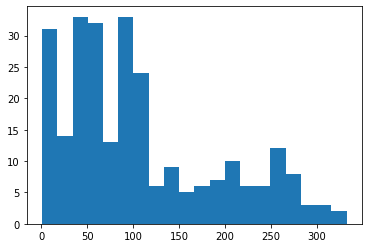

In [10]:
n, bins, patches = plt.hist(LoS, bins=20)

Now generate an empirical distribution that roughly matches as above by sampling with replacement

In [11]:
LoS_sample = LoS.sample(frac=1, replace=True)
LoS_sample.describe()

count    263.000000
mean      96.634981
std       80.698500
min        1.000000
25%       40.000000
50%       68.000000
75%      138.500000
max      305.000000
Name: hours_to_discharge, dtype: float64

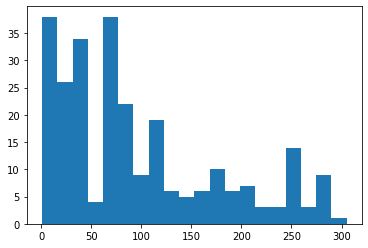

In [12]:
n, bins, patches = plt.hist(LoS_sample, bins=20)

### Department

Plot the distribution, then pick a distribution and create a simple sample

In [13]:
department = df['department']
department.value_counts()

UCH T01 ACUTE MEDICAL     36
UCH T10 SOUTH (T10S)      35
UCH T10 NORTH (T10N)      24
UCH T09 NORTH (T09N)      24
UCH T13 NORTH ONCOLOGY    24
UCH SDEC                  23
UCH T13 SOUTH (T13S)      22
UCH T08 SOUTH (T08S)      21
UCH T08 NORTH (T08N)      20
UCH T09 CENTRAL (T09C)    19
UCH T03 INTENSIVE CARE    19
UCH T12 NORTH (T12N)      18
UCH T14 NORTH TRAUMA      17
UCH T16 NORTH (T16N)      15
UCH T07 NORTH (T07N)      15
UCH T16 SOUTH WINTER      14
UCH T14 SOUTH ASU         13
UCH T06 HEAD (T06H)       12
UCH T12 SOUTH (T12S)      10
UCH T11 NORTH (T11N)       9
UCH T01 ENHANCED CARE      9
UCH T11 SOUTH (T11S)       9
UCH T07 SOUTH              7
UCH T06 CENTRAL (T06C)     6
UCH T14 NORTH (T14N)       4
UCH T06 SOUTH PACU         4
UCH T09 SOUTH (T09S)       3
UCH T06 GYNAE (T06G)       3
UCH T15 SOUTH (T15S)       2
UCH T07 SOUTH (T07S)       2
UCH T10 MED (T10M)         1
UCH T08S ARCU              1
UCH T15 NORTH (T15N)       1
UCH T11 EAST (T11E)        1
UCH T16 SOUTH 

In [14]:
X = df.groupby('department')['department'].count()

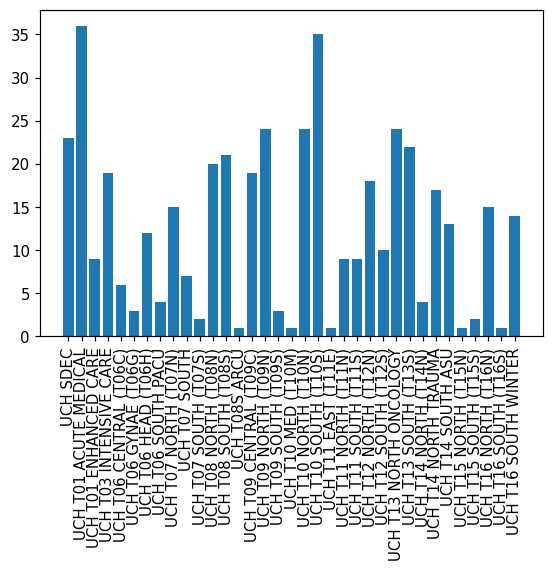

In [15]:
fig, ax = plt.subplots(dpi=1.5*72)
ax.bar(X.index, X.values)
ax.tick_params(axis='x', rotation=90)
plt.show()

Now generate an empirical distribution that roughly matches as above by sampling with replacement

In [16]:
department_sample =department.sample(frac=1, replace=True)
department_sample.value_counts()

UCH T01 ACUTE MEDICAL     45
UCH T10 SOUTH (T10S)      37
UCH T09 CENTRAL (T09C)    30
UCH T13 NORTH ONCOLOGY    26
UCH T10 NORTH (T10N)      26
UCH T09 NORTH (T09N)      25
UCH T13 SOUTH (T13S)      23
UCH T03 INTENSIVE CARE    22
UCH SDEC                  22
UCH T07 NORTH (T07N)      21
UCH T06 HEAD (T06H)       16
UCH T12 NORTH (T12N)      16
UCH T16 NORTH (T16N)      16
UCH T14 SOUTH ASU         14
UCH T08 SOUTH (T08S)      14
UCH T14 NORTH TRAUMA      12
UCH T16 SOUTH WINTER      12
UCH T08 NORTH (T08N)      11
UCH T11 NORTH (T11N)      10
UCH T11 SOUTH (T11S)       7
UCH T01 ENHANCED CARE      6
UCH T07 SOUTH              6
UCH T12 SOUTH (T12S)       5
UCH T06 SOUTH PACU         5
UCH T14 NORTH (T14N)       3
UCH T06 CENTRAL (T06C)     3
UCH T06 GYNAE (T06G)       3
UCH T15 SOUTH (T15S)       3
UCH T07 SOUTH (T07S)       1
UCH T15 NORTH (T15N)       1
UCH T16 SOUTH (T16S)       1
UCH T10 MED (T10M)         1
UCH T09 SOUTH (T09S)       1
Name: department, dtype: int64

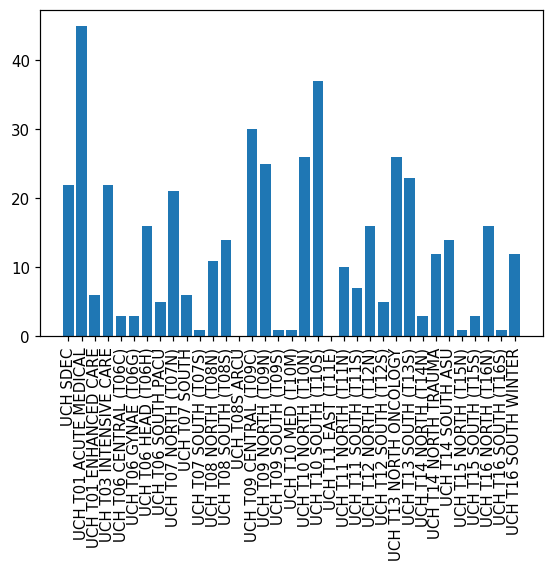

In [17]:
X_s = department_sample.value_counts()
X_s = X_s.reindex(X.index)
fig, ax = plt.subplots(dpi=1.5*72)
ax.bar(X_s.index, X_s.values)
ax.tick_params(axis='x', rotation=90)
plt.show()

### Age

Plot the distribution, then pick a distribution and create a simple sample

In [18]:
age = df['age']
age.describe()

count    444.000000
mean      57.927928
std       23.748289
min        0.000000
25%       40.000000
50%       65.000000
75%       75.000000
max      100.000000
Name: age, dtype: float64

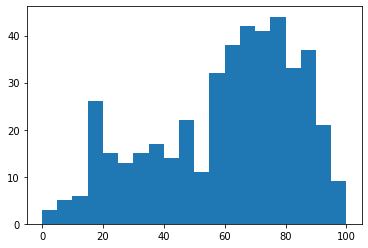

In [19]:
n, bins, patches = plt.hist(age, bins=20)

Now generate an empirical distribution that roughly matches as above by sampling with replacement

In [20]:
age_sample = age.sample(frac=1, replace=True)
age_sample.describe()

count    444.000000
mean      58.355856
std       22.933793
min        5.000000
25%       43.750000
50%       65.000000
75%       75.000000
max      100.000000
Name: age, dtype: float64

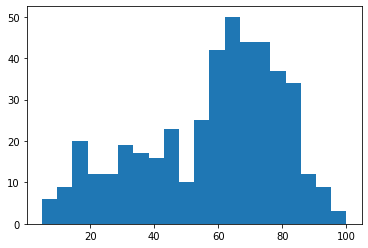

In [21]:
n, bins, patches = plt.hist(age_sample, bins=20)

### Pulse

Plot the distribution, then pick a distribution and create a simple sample

In [22]:
pulse = df['pulse']
pulse.describe()

count    381.000000
mean      81.391076
std       17.147712
min       42.000000
25%       70.000000
50%       80.000000
75%       90.000000
max      187.000000
Name: pulse, dtype: float64

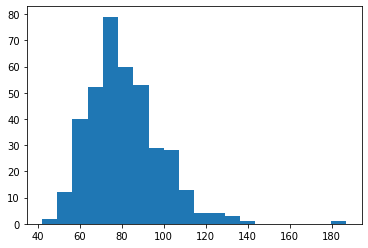

In [23]:
n, bins, patches = plt.hist(pulse, bins=20)

Now generate an empirical distribution that roughly matches as above by sampling with replacement

In [24]:
pulse_sample = pulse.sample(frac=1, replace=True)
pulse_sample.describe()

count    375.000000
mean      79.696000
std       15.435336
min       46.000000
25%       68.500000
50%       78.000000
75%       89.000000
max      133.000000
Name: pulse, dtype: float64

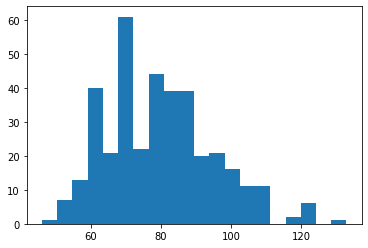

In [25]:
n, bins, patches = plt.hist(pulse_sample, bins=20)

In [31]:
pulse_sample

115     59.0
363    102.0
317     72.0
257     60.0
265      NaN
       ...  
237      NaN
118     87.0
47      78.0
253     63.0
394     77.0
Name: pulse, Length: 444, dtype: float64

## Prepare dummy data frame

In [44]:
LoS_sample.reset_index(inplace=True, drop=True)
department_sample.reset_index(inplace=True, drop=True)
age_sample.reset_index(inplace=True, drop=True)
pulse_sample.reset_index(inplace=True, drop=True)

In [45]:
df_dummy = pd.concat([LoS_sample, department_sample, age_sample, pulse_sample], axis=1)

In [47]:
df_dummy.reset_index(inplace=True)

In [51]:
df_dummy.rename({'index': 'id'}, axis=1, inplace=True)

In [52]:
df_dummy.head()

,id,hours_to_discharge,department,age,pulse
0,0,42.0,UCH T11 NORTH (T11N),60.0,59.0
1,1,NaN,UCH T03 INTENSIVE CARE,65.0,102.0
2,2,132.0,UCH T13 NORTH ONCOLOGY,60.0,72.0
3,3,206.0,UCH T01 ACUTE MEDICAL,10.0,60.0
4,4,90.0,UCH T11 SOUTH (T11S),65.0,NaN


Write dummy data out. Use sqlite to manage typing etc.

In [57]:
sqlite_engine = sa.create_engine('sqlite:///data/dummy.db')
df_dummy.to_sql('discharges', con=sqlite_engine, if_exists='replace') 